# Anomaly Detection


In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pickle

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
#%matplotlib notebook
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns
import scipy.stats as stats
# Where to save the figures
PROJECT_ROOT_DIR = "."
DATA_DIR = os.path.join(PROJECT_ROOT_DIR,'data')
IMG_DIR = os.path.join(PROJECT_ROOT_DIR, 'img')
CHAPTER_ID = "classification"


def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
def display_normal(data, xlab, ylab, anomaly = None):
    mu = data.mean()
    variance = data.std()
    sigma = np.sqrt(variance)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    fig, ax = plt.subplots()
    ax.plot(x,stats.norm.pdf(x, mu, sigma))
    ax.scatter(data,[0]*data.shape[0], color='red', marker='x')
    if anomaly:
        ax.scatter(anomaly, 0, color='green', marker='x')
    
    ax.set(xlabel=xlab, ylabel=ylab)
    return fig, ax

def display_scatter(data, xlab, ylab, anomaly=None):
    fig, ax = plt.subplots()
    ax.scatter(heat, vibrations, color='red')
    if anomaly:
        if isinstance(anomaly, int):
            ax.scatter(data[anomaly][0], data[anomaly][1], color='green', marker='x')
        else:
            ax.scatter(anomaly[0], anomaly[1], color='green', marker='x')
    _ = ax.set(xlim=(0,8),ylim=(0,10), xlabel=xlab, ylabel=ylab)
    return fig, ax

from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

def display_multivariate(location, sigma, range_x1 = [-5, 5], range_x2 = [-5, 5]):
    #Create grid and multivariate normal
    x = np.linspace(*range_x1, 500)
    y = np.linspace(*range_x2, 500)
    X, Y = np.meshgrid(x,y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X; pos[:, :, 1] = Y                             
    rv = multivariate_normal(location, sigma)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, rv.pdf(pos),cmap='viridis',linewidth=0)
    ax.set_xlabel(r'X_1 axis')
    ax.set_ylabel(r'X_2 axis')
    ax.set_zlabel('Z axis')
    return fig, ax
    

## Motivating Example
Imagine your are working in the context of aircraft manifacturing and you
are responsible for the engine of each aircraft.

Any engine is represented by the a set of features:

$$
\begin{array}{ccc}
x_1 & = & \text{heat generated} \\
x_2 & = & \text{vibration intensity} \\
\dots & & \\
\end{array}
$$

You also have a dataset: $D = \{x^{(1)}, x^{(2)}, \dots, x^{(m)}\}$.

Based on the above features, you want to be able to detect defective engines,
i.e., anomalies.

The figure below shows what at an anomaly looks like.

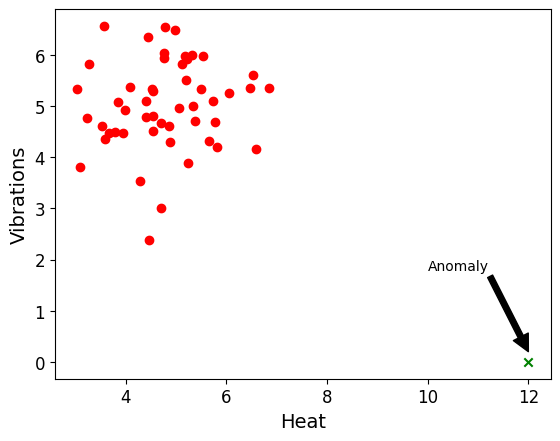

In [2]:
heat = np.random.normal(5, 1, size=50).tolist() + [12]
vibrations = np.random.normal(5, 1, size=50).tolist() + [0]
fig, ax = plt.subplots()
ax.scatter(heat[:-1], vibrations[:-1], color='red')
ax.scatter(heat[-1], vibrations[-1], color='green', marker='x')
ax.annotate("Anomaly",
              xy=(heat[-1], vibrations[-1]+0.2),  
              xytext=(heat[-1]-2, vibrations[-1]+2),
              arrowprops={"facecolor":'black'},
              horizontalalignment='left',
              verticalalignment='top' )
_ = ax.set(xlabel="Heat", ylabel="Vibrations")

Given a new engine $x_{test}$, how can we decide if it should be
regarded as an anomaly or not? 

- We can build probabilistic model from our data. 
  Then, we can use the probability density function learned from the data 
  to classify a new sample as an anomaly.
  
For instance, we can establish the following rule:
- Given a certain threshold $\epsilon$

$$
\begin{array}{cccc}
\text{(i)} & \text{if} & p(x_{test}) < \epsilon & x_{test}\text{ is an anomaly}\\
\text{(ii)} & \text{if} & p(x_{test}) \geq \epsilon & x_{test}\text{ is NOT an anomaly}
\end{array}
$$

## The Gaussian Distribution
The notion of anomaly is related to the concept of _deviation_ from 
a standard distribution.

Let's revise some fundamental concepts about the gaussian distribution.

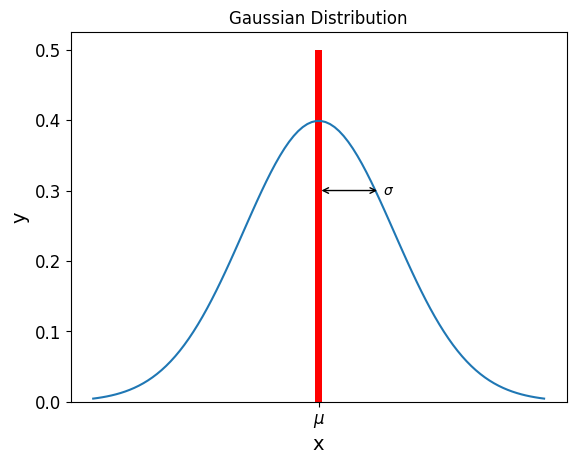

In [3]:
mu = 0
variance = 1
sigma = np.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
fig, ax = plt.subplots()
ax.plot(x, stats.norm.pdf(x, mu, sigma))
ax.bar(0, 0.5, width=.1, tick_label=r"$\mu$", color="red")
ax.bar(0, 0.5, width=.1, tick_label=r"$\mu$", color="red")
plt.title("Gaussian Distribution")
ax.set(xlabel="x", ylabel="y")


ax.annotate(r"$\sigma$",
              xy=(0, 0.3),  
              xytext=(1, 0.3),
              arrowprops={"facecolor":'red', "arrowstyle":'<->'},
              horizontalalignment='right',
              verticalalignment='center')

plt.show()

A normal distributed variable $x$ is denoted by $x \sim \mathcal{N}(\mu,\sigma^2)$, where:
- $\mu$ denotes the mean
- $\sigma$ denotes is the standard deviation - $\sigma^2$ is the variance.

The density function is defined as:


$$
p(x; \mu, \sigma^2) = \frac{1}{\sigma\sqrt{2\pi}} \exp\big(-\frac{(x-\mu)^2}{2\sigma^2} \big)
$$

Intuitively: 
- larger values of $\sigma$ make the shape of the curve wider and shorter
- smaller values of $\sigma$ make the shape of the curve thinner and taller 
- the  value of $\mu$ shifts the entire curve on the x-axis.


### Fitting the normal distribution - Maximum Likelihood Estimation (MLE)
We need to estimate both the values of $\mu$ and $\sigma$. 

$$
\begin{array}{ccc}
\mu & = & \frac{1}{m} \sum_{i} x^{(i)}\\
\sigma^2 & = & \frac{1}{m} \sum_{i} (x^{(i)} - \mu)^2 
\end{array}
$$

The above estimation is based on a single important assumption: data are distributed according
to a normal distribution (__You need to verify this assumption__).

## Anomaly Detection Algorithm
Given a training set $D = \{x^{(1)}, x^{(2)}, \dots, x^{(m)}\}$, __assuming each 
feature i is distributed according to its own normal distribution with parameters
$\mu_i$ and $\sigma_i$__ We can compute the probability of a sample $x \in \mathbf{R}^N$ as:

$$
p(x) = \prod_{i}p(x_i; \mu_i,  \sigma_i^2)
$$

The above product defines a probability distribution which is also a Gaussian.


### Putting all together 
1. Choose features $x_i$ that might be indicative for an anomalous example. 
2. Fit the parameters with MLE 
3. Label a new example x as an anomaly if:
$$
p(x) = \prod_{i}p(x_i; \mu_i,  \sigma_i^2) < \epsilon
$$

__Note__: The entire algorithm assumes the features are independent from one another.

Nonetheless, the approach works sufficiently well even though the above assumption does not hold.


### Performance Analysis
We are interested in finding a single metric of evaluation.

With a little of imagination we can reduce the anomaly detection problem to a classification
problem. More specifically, it is similar to a binary classification problem, where the target
variable is 1 whenever a sample is regarded as an anomaly.

A typical scenario is the following: 
- Training Set: a set of unlabeled data. This samples are used to MLE, thus to reconstruct the 
  probability distribution of the so called _normal examples_
- Validation and Test Set. These are collections of labeled data of the form $(x_{cv},y_{cv})$ and
  $(x_{test}, y_{test})$  for the validation and the test set respectively.
  
  
  
While the training set has to contain the samples regarded as normal, the last two datasets 
have both a combination normal samples and anomalies. 

Usually, anomalies are far less than the number of normal samples. 
A typical scenario would be the following: 
- Original Data: 

$$
\begin{array}{ccc}
10.000 & - & \text{good engines} \\
20 & - & \text{flawed engines} 
\end{array}
$$
splitted into: 

| Segment        | Normal (y=0) | Flawed (y=1) |
|:--------------:|:------------:|:------------:|
| Training Set   | 6000         | 0            |
| Validation Set | 2000         | 10           |
| Test Set       | 2000         | 10           |


Given the above splitting, the evaluation is carried out as follow:

1. Fit the model to estimate $p(x)$ on the __Training Set__
2. Choose e value for $\epsilon$ and classify all the points in the __Validation Set__
3. Evaluate the quality of the classification according to either one of the following metrics:
   1. Accuracy (really?)
   2. Precision
   3. Recall
   4. F1-Score
4. Return to step 2 and try with a different value of $\epsilon$.

At the end of step 4, after you have established the best value of 
$\epsilon$ with respect to the performace reported on the validation set, 
compute quality of your solution on the  __Test Set__.

### Recap
Summarize the main differences and analogies between the 
anomaly detection problem and the classification problem:

 | Anomaly Detection | Classification |
 |-------------------|----------------|
 |There is a small number of "positive" samples                   |      Data are more balanced          |
 |Requires few "positive" sample                   |                |
 
### Tips and tricks
One of the key assumption of the above approach is that data needs to be
distributed according to some normal distribution. 

Therefore, it is of paramount importance  to check this assumption before applying 
the algorithm. 




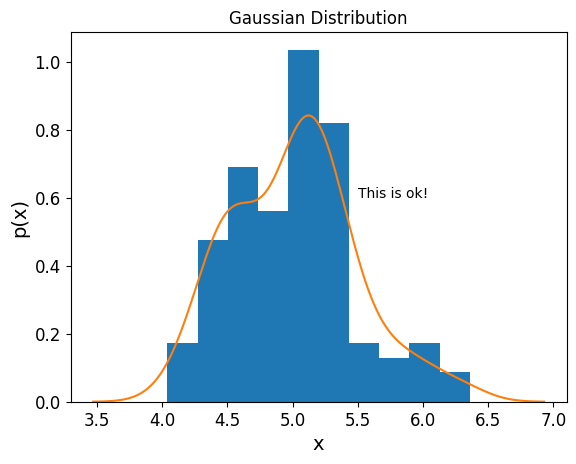

In [4]:
data = np.random.normal(5, .5, size=100).tolist() 
fig, ax = plt.subplots()
ax.hist(data, density=True, )
sns.kdeplot(data)
plt.title("Gaussian Distribution")
ax.text(5.5, 0.6, "This is ok!")
_ = ax.set(xlabel="x", ylabel="p(x)")

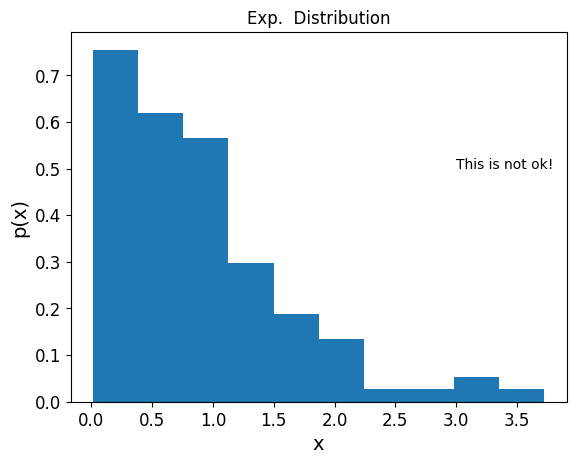

In [5]:
data = np.random.exponential(1, 100) 
fig, ax = plt.subplots()
ax.hist(data, density=True)
plt.title("Exp.  Distribution")
ax.text(3, 0.5, "This is not ok!")
_ = ax.set(xlabel="x", ylabel="p(x)")


Sometimes it is required a little effort to enforce a normal distribution

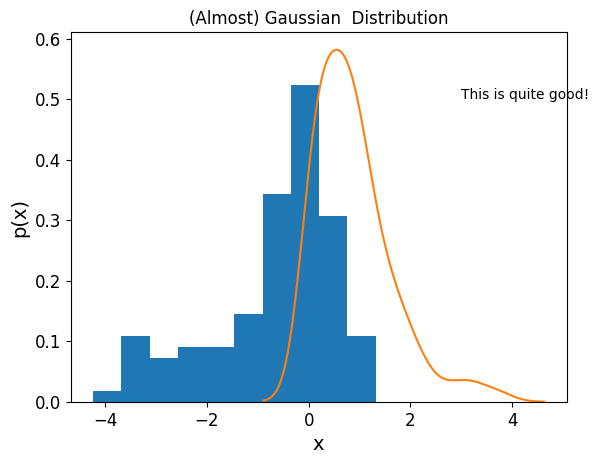

In [6]:
c = 0
fig, ax = plt.subplots()
ax.hist(np.log(data+c), density=True)
sns.kdeplot(data)
plt.title("(Almost) Gaussian  Distribution")
ax.text(3, 0.5, "This is quite good!")
_ = ax.set(xlabel="x", ylabel="p(x)")


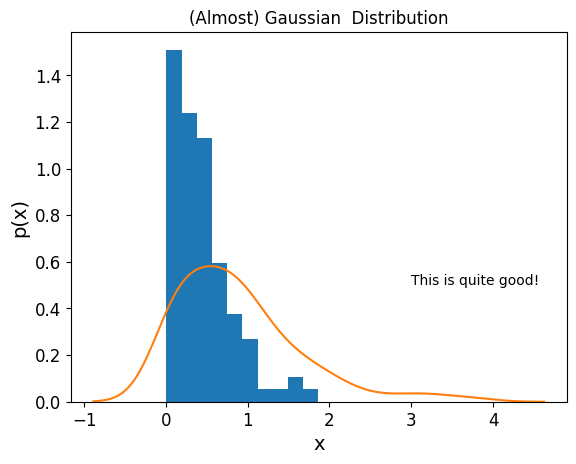

In [7]:
c = 2
fig, ax = plt.subplots()
ax.hist(data ** 1/c, density=True)
sns.kdeplot(data)

plt.title("(Almost) Gaussian  Distribution")
ax.text(3, 0.5, "This is quite good!")
_ = ax.set(xlabel="x", ylabel="p(x)")


## Feature Selection
Feature selection is not an easy task. 
There are two main strategies:
1. Looking at the attributes distribution independently from one another
2. Looking at the joint distribution of two or more variables. 

Clearly, the first strategy is very simple. 

However, it is not able to detect the following situation.

Imagine you already know there is a flawed engine. 

Let's see what happens when you plot your data
separately.

__Heat__

In [8]:
anomaly = [5, 5.1] #
heat = np.random.normal(5, 1, size=50)
vibrations = np.random.normal(7, 1, size=50)

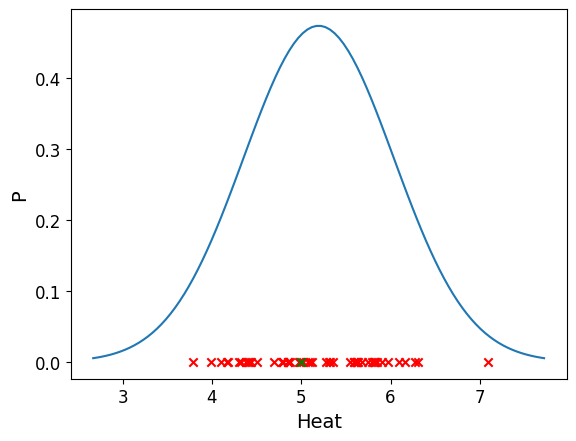

In [9]:
mu = heat.mean()
variance = heat.std()
sigma = np.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
fig, ax = plt.subplots()
ax.plot(x,stats.norm.pdf(x, mu, sigma))
ax.scatter(heat,[0]*heat.shape[0], color='red', marker='x')
ax.scatter(anomaly[0],0, color='green', marker='x')
_ = ax.set(xlabel="Heat", ylabel="P")

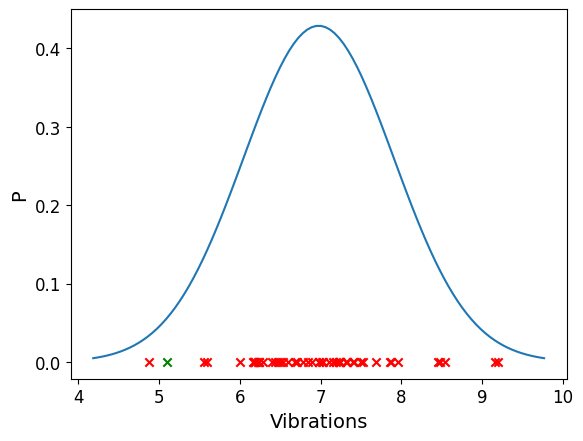

In [10]:
mu = vibrations.mean()
variance = vibrations.std()
sigma = np.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
fig, ax = plt.subplots()
ax.plot(x,stats.norm.pdf(x, mu, sigma))
ax.scatter(vibrations,[0]*heat.shape[0], color='red', marker='x')
ax.scatter(anomaly[1],0, color='green', marker='x')
_ = ax.set(xlabel="Vibrations", ylabel="P")

__Vibration__ vs __Heat__

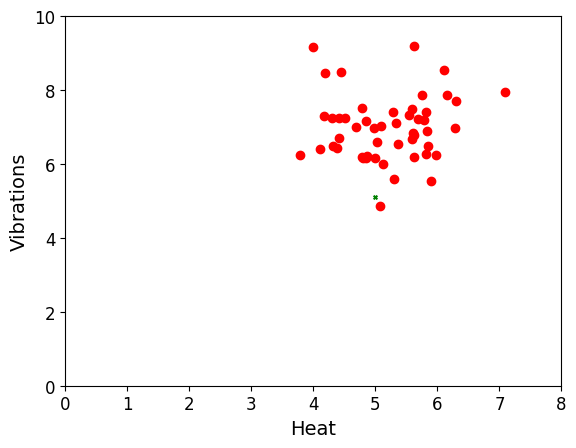

In [11]:
fig, ax = plt.subplots()
ax.scatter(heat, vibrations, color='red')
ax.scatter(anomaly[0], anomaly[1], vibrations[-1], color='green', marker='x')
_ = ax.set(xlim=(0,8),ylim=(0,10), xlabel="Heat", ylabel="Vibrations")


From the above figure is clear that the green point represents an anomaly.

__Traps to avoid__

A common problem when determining the proper set of features
to train the model is when anomalous and normal sample have
comparable probabilities.

The probability of the anomalous sample is given by:


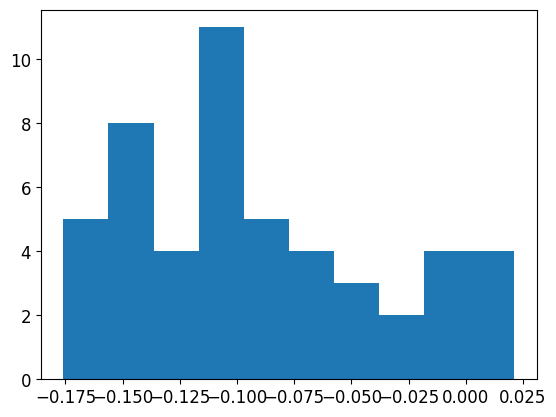

In [12]:

heat_mu, heat_sigma = heat.mean(), np.sqrt(heat.std())
vib_mu, vib_sigma = vibrations.mean(), np.sqrt(vibrations.std())

def p(x, mu, sigma):
    power = -.5 *((x-mu)/sigma)**2
    return 1/(sigma * np.sqrt(2*np.pi))*np.exp(power)

anomaly_p = p(anomaly[0], heat_mu, heat_sigma)*p(anomaly[1], vib_mu, vib_sigma)
normal_p = p(heat, heat_mu, heat_sigma) * p(vibrations, vib_mu, vib_sigma)


_ = plt.hist(anomaly_p-normal_p, bins=10)

If we compare the probability of the anomaly, we notice that it is inconveniently
close with any other normal sample. 

__How can we solve this problem?__
You can come up with new features.

For instance, what happens if we divide the create a new feature
as follows:

$$
x_3 = \frac{\text{heat}}{\text{vibrations}}
$$



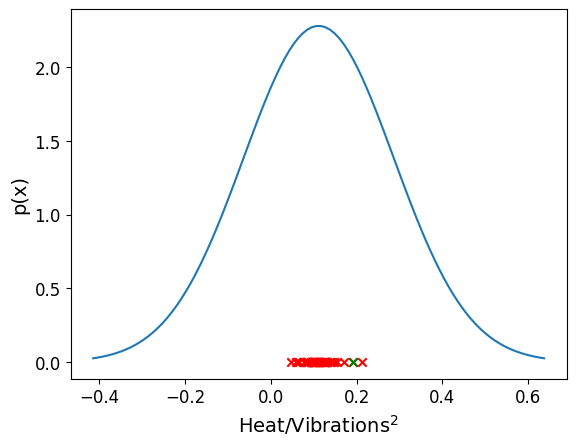

In [13]:
x3 = heat/(vibrations**2)

_ = display_normal(x3, r"Heat/Vibrations$^2$", "p(x)", anomaly[0]/anomaly[1]**2)

The new feature allows us to immediately spot the flawed engine!

## Multivariate Gaussian

A major weakness of the above strategy is the inability to reason about a bivariate 
perspective. 

Let's see the following example. 

__Monitoring Machines in a data center__

We want to detect anomalies based on the amount of CPU and memory used by a
process. 

We might have the followng situation.

In [14]:
cpu = np.sort(np.random.normal(5, 2, size=50))
memory = np.sort(np.random.normal(5,2 , size=50))
anomaly = [3.2, 7]
data = np.c_[cpu, memory]

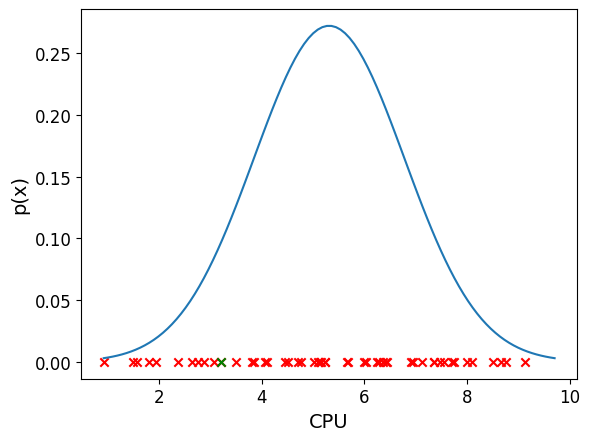

In [15]:
_ = display_normal(cpu, "CPU", "p(x)", anomaly[0])

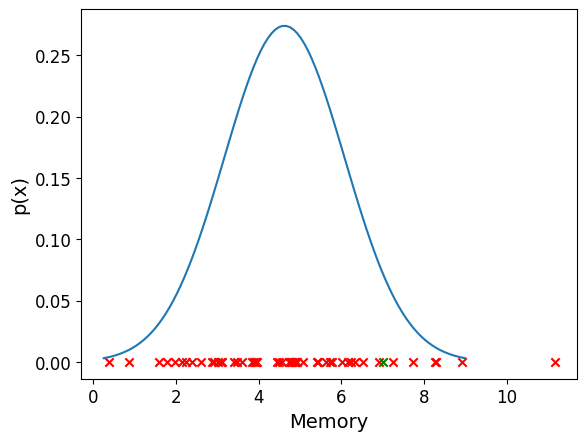

In [16]:
_ = display_normal(memory, "Memory", "p(x)", anomaly[1])

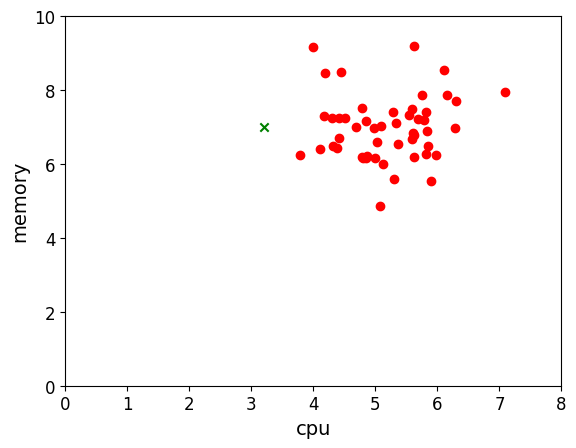

In [17]:
_ = display_scatter(data, "cpu", "memory", anomaly)

The above plot appears to suggest that memory increases with the cpu load. 

Clearly, the green point represents an anomaly, as it couples a low cpu load with 
a high memory sonsumption.

Nonetheless, if we had not plot the bivariate scatter plot, we would not 
be able to detect this anomaly. 

The main problem with the algorithm discussed in the previous section is that 
it is unable to adopt a bivariate perspective -- __this is due to the assumptions that variables/atributes are independent from each others!__

Using a multivariate normal distribution, the probability of a sample $p(x)$ is not considered as 
the product of independent normally distributed variables, but $x$ becomes a multivariate variable.

Therefore we need a new set of parameters:

$$
\begin{array}{cc}
\mu \in \mathbf{R}^n & \text{location} \\
\Sigma \in \mathbf{R}^{n \times n} & \text{covariance matrix} 
\end{array} 
$$

A multivariate normal distribution is then defined as:

$$
p(x; \mu, \Sigma) = \frac{1}{(2\pi)^{n/2} det(\Sigma)^{1/2}} \,\exp\big(-\frac{1}{2}(x-\mu)^T \Sigma^{-1} (x-\mu)\big)
$$

### What a multivariate normal distribution looks like? 
We need to define the required parameters:

<IPython.core.display.Javascript object>


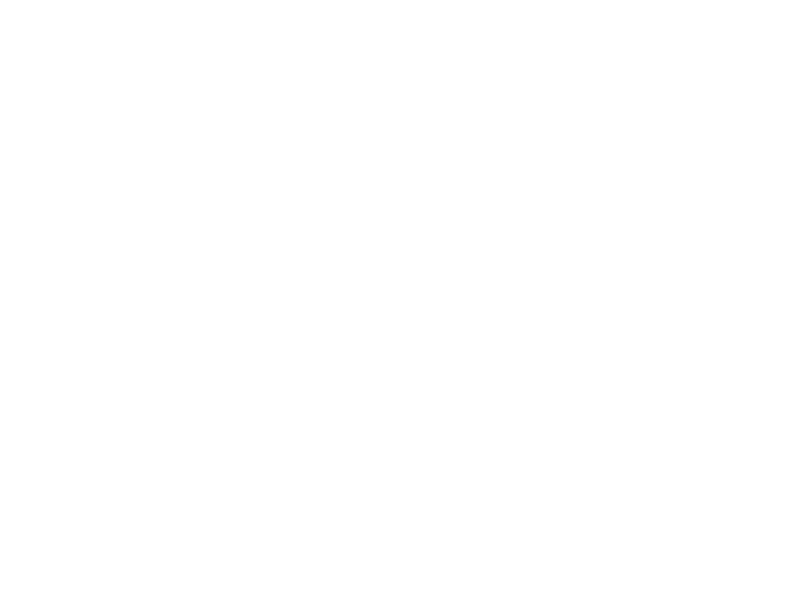

TypeError: gca() got an unexpected keyword argument 'projection'

In [18]:
%matplotlib notebook
location = [1, 0]

sigma = [[2.0, 0], 
         [0, 2.0]]

_ = display_multivariate(location, sigma)

__Questions__

1. What happen when you change the location vector?
2. What happen when you change the element on the main diagonal of the covariance matrix?
3. What happen when you change the element not on the main diagonal of the covariance matrix?
4. What is the relation between the multivariate approach and the previous one?
   Hint: Focus on the covariance matrix. 
   
   
# Original Model vs Multivariate 

| Question       | Original Model |  Multivariate|
|:--------------:|:------------:|:------------:|
| requires manual feat. eng.   |     |    |
| easy to train                |     |    |
| requires a lot of data       |     |    |







